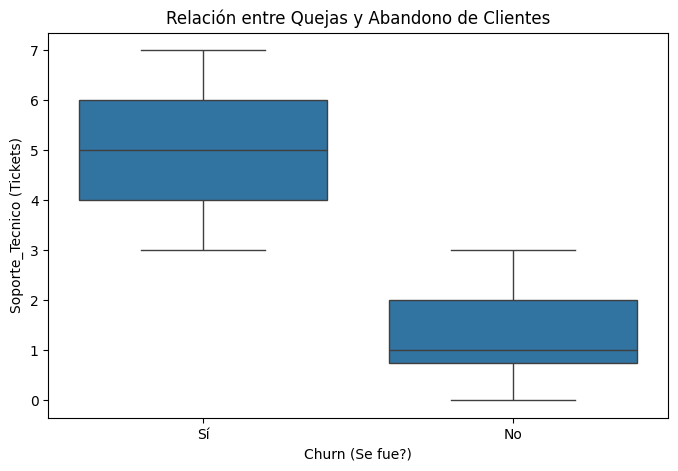

--- CLIENTES CON ALTO RIESGO DE CANCELACIÓN ---
    ID_Cliente  Gasto_Mensual  Soporte_Tecnico (Tickets)
0            1           70.5                          5
4            5           98.6                          4
7            8           69.9                          6
10          11           75.2                          4
12          13           85.1                          7
15          16           95.0                          5
18          19           77.8                          4
20          21           99.1                          5
22          23           68.3                          4
25          26           88.4                          4
27          28           72.2                          6
30          31           82.1                          5
32          33           90.5                          6
35          36           98.4                          5
38          39           80.3                          4
40          41          102.3           

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Cargar los datos
df_general = pd.read_excel('datos_clientes_general.xlsx')

# 2. Análisis Visual (¿Por qué se van?)
# Vamos a ver si los que tienen más tickets de soporte son los que más se van
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn (Se fue?)', y='Soporte_Tecnico (Tickets)', data=df_general)
plt.title('Relación entre Quejas y Abandono de Clientes')
plt.show()

# 3. La Lógica de Predicción (Simplificada)
# ¿Quiénes tienen alto riesgo?
riesgo_alto = df_general[(df_general['Soporte_Tecnico (Tickets)'] > 3) & (df_general['Tipo_Contrato'] == 'Mes a mes')]

print("--- CLIENTES CON ALTO RIESGO DE CANCELACIÓN ---")
print(riesgo_alto[['ID_Cliente', 'Gasto_Mensual', 'Soporte_Tecnico (Tickets)']])

In [8]:
# 1. Definimos los pesos (La importancia de cada factor)
# Le damos más peso a los tickets de soporte porque suelen ser la causa principal
PESO_TICKETS = 15
PESO_CONTRATO_MES = 25

# 2. Creamos la función para calcular el puntaje
def calcular_score_riesgo(fila):
    score = 0

    # Sumamos puntos por cada ticket de soporte
    score += (fila['Soporte_Tecnico (Tickets)'] * PESO_TICKETS)

    # Si el contrato es mes a mes, el riesgo sube mucho
    if fila['Tipo_Contrato'] == 'Mes a mes':
        score += PESO_CONTRATO_MES

    # Si ya tiene mucha antigüedad, el riesgo baja un poco (es un cliente fiel)
    # Corregido: Meses_Antiguedad en lugar de Mes_Antiguedad
    if fila['Meses_Antiguedad'] > 24:
        score -= 10

    # Aseguramos que el score esté entre 0 y 100
    return max(0, min(100, score))

# 3. Aplicamos el cálculo
df_general['Score_Riesgo'] = df_general.apply(calcular_score_riesgo, axis=1)

# 4. Mostramos el ranking de clientes a salvar
ranking_retencion = df_general.sort_values(by='Score_Riesgo', ascending=False)
print(ranking_retencion[['ID_Cliente', 'Soporte_Tecnico (Tickets)', 'Tipo_Contrato', 'Score_Riesgo']])

    ID_Cliente  Soporte_Tecnico (Tickets) Tipo_Contrato  Score_Riesgo
0            1                          5     Mes a mes           100
15          16                          5     Mes a mes           100
12          13                          7     Mes a mes           100
7            8                          6     Mes a mes           100
30          31                          5     Mes a mes           100
..         ...                        ...           ...           ...
68          69                          0      Dos años             0
83          84                          0      Dos años             0
74          75                          0      Dos años             0
88          89                          0      Dos años             0
94          95                          0      Dos años             0

[100 rows x 4 columns]


In [9]:
# 1. Agrupamos por 'Tipo_Contrato' y calculamos el promedio del Score de Riesgo
# Esto nos dice en qué grupo de clientes debemos preocuparnos más
resumen_contrato = df_general.groupby('Tipo_Contrato')['Score_Riesgo'].mean().reset_index()

# 2. Renombramos las columnas para que el cliente lo entienda fácil
resumen_contrato.columns = ['Tipo de Contrato', 'Riesgo Promedio (0-100)']

# 3. Ordenamos de mayor a menor riesgo
resumen_contrato = resumen_contrato.sort_values(by='Riesgo Promedio (0-100)', ascending=False)

print("--- RESUMEN EJECUTIVO DE RIESGO POR CONTRATO ---")
print(resumen_contrato)

# 4. EXPORTACIÓN: Creamos el archivo Excel para entregar al cliente
# Combinamos los datos originales con el Score de Riesgo y el Resumen
with pd.ExcelWriter('Analisis_Retencion_Final.xlsx') as writer:
    df_general.sort_values(by='Score_Riesgo', ascending=False).to_excel(writer, sheet_name='Ranking_Clientes', index=False)
    resumen_contrato.to_excel(writer, sheet_name='Resumen_Gerencial', index=False)

print("\n¡Listo! El archivo 'Analisis_Retencion_Final.xlsx' ha sido creado.")

--- RESUMEN EJECUTIVO DE RIESGO POR CONTRATO ---
  Tipo de Contrato  Riesgo Promedio (0-100)
2        Mes a mes                84.727273
0            Anual                15.800000
1         Dos años                 1.250000

¡Listo! El archivo 'Analisis_Retencion_Final.xlsx' ha sido creado.


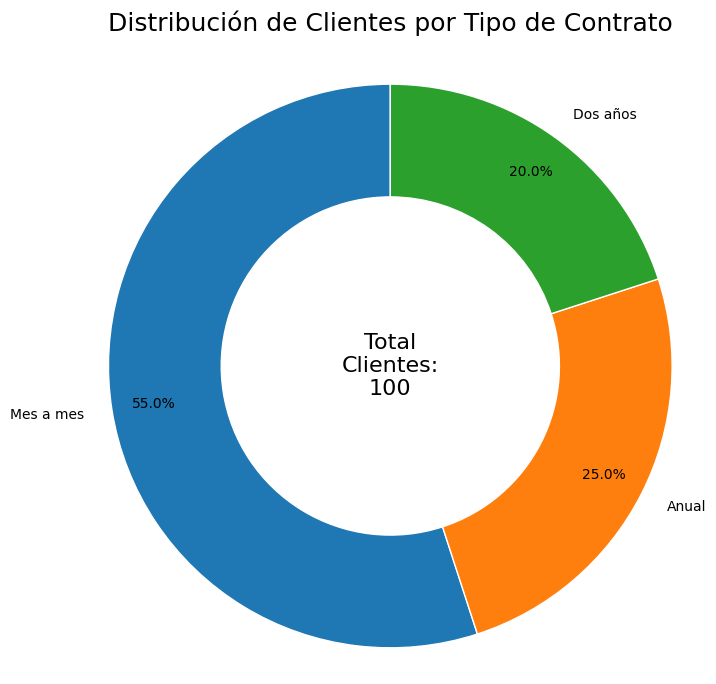

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargamos el archivo de Excel
df = pd.read_excel('datos_clientes_general.xlsx')

# 2. Contamos la frecuencia de cada tipo de contrato
contrato_counts = df['Tipo_Contrato'].value_counts()

# 3. Preparamos los datos para el gráfico de anillo
labels = contrato_counts.index
sizes = contrato_counts.values
total_clientes = sum(sizes)

# Colores profesionales y sin estridencias
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 4. Creamos la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 8)) # Ajusta el tamaño para una mejor visibilidad

# Creamos el gráfico de torta con un wedgeprops para crear el hueco
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%', # Formato para mostrar porcentajes
    startangle=90,
    colors=colors,
    pctdistance=0.85, # Distancia del porcentaje desde el centro
    wedgeprops=dict(width=0.4, edgecolor='w') # Ancho del anillo y color del borde
)

# Añadimos el texto central (el "Total")
center_circle = plt.Circle((0,0), 0.60, fc='white') # Fondo blanco para el centro
fig.gca().add_artist(center_circle)

# Agregamos la anotación del total de clientes en el centro
ax.text(0, 0, f'Total\nClientes:\n{total_clientes}',
        ha='center', va='center', fontsize=16, color='black')

# Título del gráfico
ax.set_title('Distribución de Clientes por Tipo de Contrato', fontsize=18, pad=20)

# Aseguramos que el círculo sea un círculo
ax.axis('equal')

# 5. Guardar el gráfico como una imagen (PNG para portafolio)
plt.savefig('grafico_anillo_contratos_plano.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico (opcional, si lo corres en un entorno interactivo)
plt.show()